# 🚗 자동차 센서 데이터 분석 실습 노트북
본 노트북에서는 Python을 활용하여 자동차의 센서 데이터를 불러오고, 전처리 및 분석하는 과정을 실습합니다.

In [1]:
# 📦 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')

## 📁 데이터 불러오기

In [2]:
import gdown
import zipfile
import os

file_id = "1kqut3OQ5T0UpccE2LdxSD5UaPbbb-1ja"
gdown.download(f"https://drive.google.com/uc?id={file_id}", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1kqut3OQ5T0UpccE2LdxSD5UaPbbb-1ja
To: /content/sensor_data.zip
100%|██████████| 23.9k/23.9k [00:00<00:00, 25.9MB/s]


'sensor_data.zip'

In [3]:
zip_path = "/content/sensor_data.zip"

extract_path = "sensor_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"압축 해제 완료")

압축 해제 완료


In [4]:
# Google Colab 환경일 경우 아래 주석을 해제하고 파일 업로드
# from google.colab import files
# uploaded = files.upload()

speed_df = pd.read_csv('./sensor_data/speed.csv', parse_dates=['timestamp'])
accel_df = pd.read_csv('./sensor_data/accel.csv', parse_dates=['timestamp'])
gps_df = pd.read_csv('./sensor_data/gps.csv', parse_dates=['timestamp'])

## 🔗 데이터 병합 및 결측치 처리

In [5]:
merged_df = pd.merge_asof(speed_df.sort_values('timestamp'),
                           accel_df.sort_values('timestamp'),
                           on='timestamp')
merged_df = pd.merge_asof(merged_df.sort_values('timestamp'),
                          gps_df.sort_values('timestamp'),
                          on='timestamp')

# 결측치 보간
merged_df.set_index('timestamp', inplace=True)
merged_df = merged_df.interpolate(method='time').dropna()
print(merged_df.head())

merged_df.reset_index(inplace=True)

                     speed_kmh   accel_x   accel_y   accel_z  latitude  \
timestamp                                                                
2024-01-01 12:00:00        0.0  0.130090 -0.097807  9.790640  37.56650   
2024-01-01 12:00:01        0.0 -0.048573 -0.002489  9.797871  37.56651   
2024-01-01 12:00:02        0.0  0.013005 -0.119345  9.817519  37.56652   
2024-01-01 12:00:03        0.0 -0.013149  0.051541  9.805067  37.56653   
2024-01-01 12:00:04        0.0 -0.035554 -0.038407  9.782433  37.56654   

                      longitude  
timestamp                        
2024-01-01 12:00:00  126.978000  
2024-01-01 12:00:01  126.978015  
2024-01-01 12:00:02  126.978030  
2024-01-01 12:00:03  126.978045  
2024-01-01 12:00:04  126.978061  


## 📊 속도 시각화

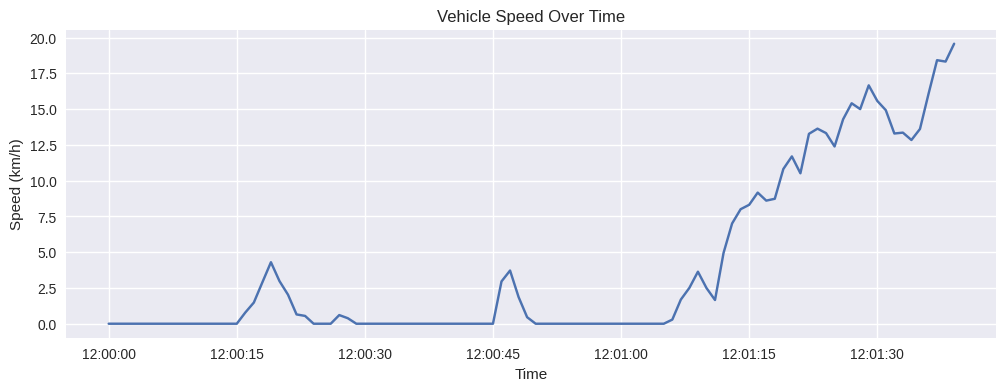

In [6]:
plt.figure(figsize=(12, 4))
plt.plot(merged_df['timestamp'], merged_df['speed_kmh'])
plt.title("Vehicle Speed Over Time")
plt.xlabel("Time")
plt.ylabel("Speed (km/h)")
plt.grid(True)
plt.show()

## ⚠️ 급가속/급감속 이벤트 탐지

In [7]:
merged_df['delta_speed'] = merged_df['speed_kmh'].diff()
merged_df['delta_time'] = merged_df['timestamp'].diff().dt.total_seconds()
merged_df['acceleration'] = merged_df['delta_speed'] / merged_df['delta_time']

rapid_event_df = merged_df[(merged_df['acceleration'] > 2) | (merged_df['acceleration'] < -2)]
rapid_event_df[['timestamp', 'speed_kmh', 'acceleration']]

,timestamp,speed_kmh,acceleration
46,2024-01-01 12:00:46,2.957147,2.957147
72,2024-01-01 12:01:12,4.947967,3.290576
73,2024-01-01 12:01:13,7.004561,2.056594
79,2024-01-01 12:01:19,10.811472,2.080616
82,2024-01-01 12:01:22,13.269924,2.757477
96,2024-01-01 12:01:36,16.057735,2.448475
97,2024-01-01 12:01:37,18.416246,2.358511


## 🗺️ GPS 경로 시각화

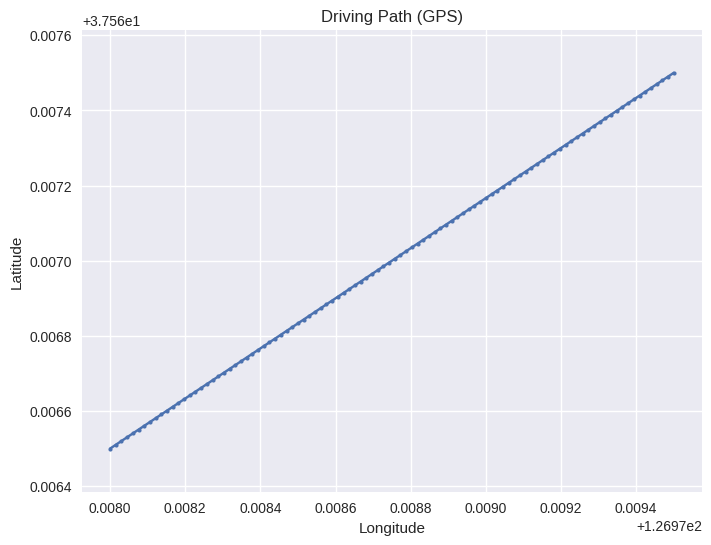

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(merged_df['longitude'], merged_df['latitude'], marker='o', markersize=3)
plt.title("Driving Path (GPS)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis('equal')
plt.grid(True)
plt.show()

## 📌 요약 통계

In [9]:
print("평균 속도:", merged_df['speed_kmh'].mean())
print("최대 속도:", merged_df['speed_kmh'].max())
print("급가속 이벤트 수:", len(rapid_event_df))

평균 속도: 3.9559943709601715
최대 속도: 19.567260429809032
급가속 이벤트 수: 7


##🎯 시계열 예측 (LSTM을 활용한 속도 예측)

- LSTM을 이용해 speed_kmh 시계열 데이터를 학습하고 향후 몇 초간의 속도를 예측

- 데이터 전처리, 시퀀스 생성, 모델 학습 및 예측까지 단계별로 진행

🔹 Step 1: 필요 라이브러리 설치 및 불러오기

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

🔹 Step 2: 데이터 로딩 및 준비

In [11]:
# CSV 파일 불러오기
df = pd.read_csv('./sensor_data/speed.csv', parse_dates=['timestamp'])

# 속도만 사용
speed = df[['speed_kmh']].values

# 정규화
scaler = MinMaxScaler()
speed_scaled = scaler.fit_transform(speed)

🔹 Step 3: 시계열 데이터 시퀀스 생성

In [12]:
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 10  # 입력 시퀀스 길이
X, y = create_sequences(speed_scaled, SEQ_LEN)

# 학습/테스트 분리
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

🔹 Step 4: LSTM 모델 구성 및 학습

In [13]:
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 0.0059 - val_loss: 0.1497
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0053 - val_loss: 0.1242
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0064 - val_loss: 0.1227
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0051 - val_loss: 0.1262
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0042 - val_loss: 0.1238
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0052 - val_loss: 0.1126
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0035 - val_loss: 0.1049
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0035 - val_loss: 0.0974
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0033 - val_loss: 0.0929
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0031 - val_loss: 0.0898
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0045 - val_loss: 0.0831
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0033 - val_loss: 0.0819


🔹 Step 5: 예측 및 시각화

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


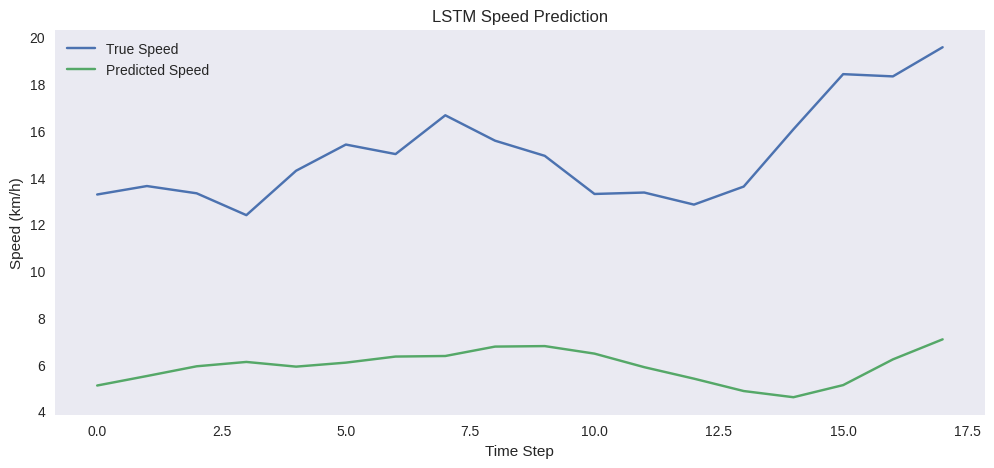

In [14]:
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='True Speed')
plt.plot(y_pred_inv, label='Predicted Speed')
plt.title("LSTM Speed Prediction")
plt.xlabel("Time Step")
plt.ylabel("Speed (km/h)")
plt.legend()
plt.grid()
plt.show()

##🚗 다변량 시계열 예측: 자동차 센서 데이터로 속도 예측


🔍 실습 목표

- 다중 센서 데이터를 활용한 다변량 시계열 예측

- 입력: 가속도(x, y, z), 위치(lat/lon), 과거 속도

- 출력: 미래 1초 후의 속도 예측

- 모델: LSTM 및 Transformer 기반 비교

📦 라이브러리 불러오기

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

📁 데이터 불러오기 및 전처리

In [16]:
# CSV 파일 로드
df = pd.read_csv('./sensor_data/merged_multisensor_data.csv', parse_dates=['timestamp'])
df = df.drop(columns=['timestamp'])  # 타임스탬프 제거 (LSTM에 직접 사용하지 않음)

# 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

# 시퀀스 생성 함수
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length][0])  # speed_kmh 예측
    return np.array(X), np.array(y)

SEQ_LEN = 10
X, y = create_sequences(data_scaled, SEQ_LEN)

X.shape, y.shape

((190, 10, 6), (190,))

🧠 LSTM 모델 학습

In [17]:
# 데이터 분할
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM 모델 정의
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, X.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.1)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.1832 - val_loss: 0.0459
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0250 - val_loss: 0.0179
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0074 - val_loss: 0.0426
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0018 - val_loss: 6.3820e-04
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0012 - val_loss: 5.8404e-04
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 9.6598e-04 - val_loss: 0.0023
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 9.1390e-04 - val_loss: 0.0012
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.7720e-04 - val_loss: 0.0010
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.6871e-04 - val_loss: 8.2174e-04
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.9493e-04

📊 LSTM 예측 시각화

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


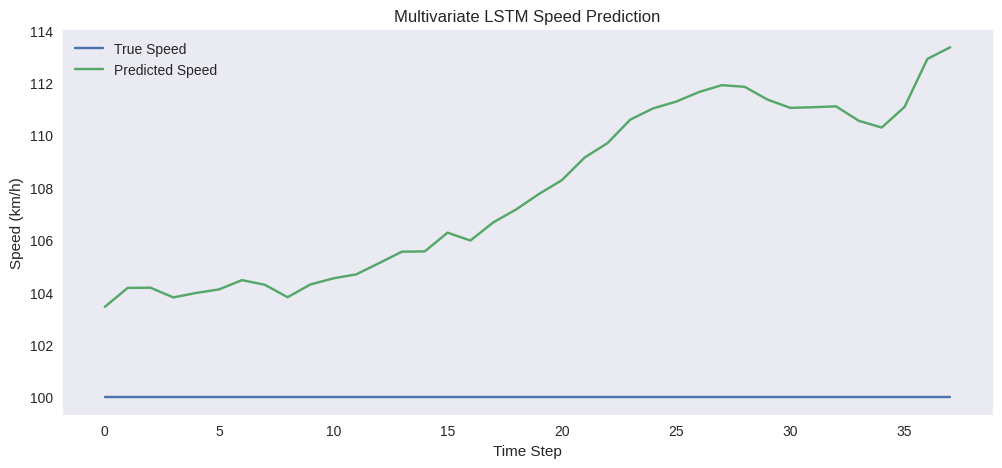

In [18]:
# 예측
y_pred = model.predict(X_test)

# 역변환
speed_scaler = MinMaxScaler()
speed_scaler.min_, speed_scaler.scale_ = scaler.min_[0], scaler.scale_[0]
y_test_inv = y_test / speed_scaler.scale_ + speed_scaler.min_
y_pred_inv = y_pred[:, 0] / speed_scaler.scale_ + speed_scaler.min_

# 시각화
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='True Speed')
plt.plot(y_pred_inv, label='Predicted Speed')
plt.title("Multivariate LSTM Speed Prediction")
plt.xlabel("Time Step")
plt.ylabel("Speed (km/h)")
plt.legend()
plt.grid()
plt.show()

🔁 Transformer 기반 예측 모델

In [19]:
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Transformer 블록 정의
def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LayerNormalization()(inputs)
    x = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = Dropout(0.2)(x)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

# 모델 생성 및 학습
transformer_model = build_transformer_model((SEQ_LEN, X.shape[2]))
transformer_model.compile(optimizer=Adam(1e-4), loss='mse')
transformer_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.1)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2778 - val_loss: 0.9994
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2430 - val_loss: 1.0104
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2323 - val_loss: 0.9952
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2346 - val_loss: 0.9489
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2003 - val_loss: 0.9079
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1894 - val_loss: 0.8515
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1565 - val_loss: 0.8023
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1495 - val_loss: 0.7397
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1456 - val_loss: 0.6767
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1211 - val_loss: 0.6244
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1204 - val_loss: 0.5634
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0960 - val_loss: 0.5204
E

📈 Transformer 예측 결과 시각화

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


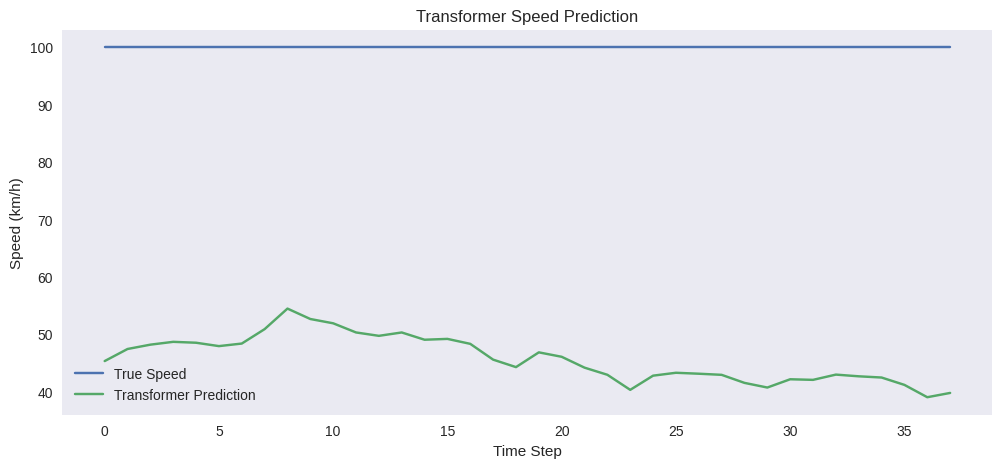

In [20]:
y_pred_tf = transformer_model.predict(X_test)
y_pred_tf_inv = y_pred_tf[:, 0] / speed_scaler.scale_ + speed_scaler.min_

plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='True Speed')
plt.plot(y_pred_tf_inv, label='Transformer Prediction')
plt.title("Transformer Speed Prediction")
plt.xlabel("Time Step")
plt.ylabel("Speed (km/h)")
plt.legend()
plt.grid()
plt.show()

##🚗 차량 센서 데이터 이상 탐지 실습 (Autoencoder 기반)

이 실습에서는 Autoencoder 딥러닝 모델을 활용하여 차량 속도 데이터를 기반으로 이상 가속도 구간을 자동으로 탐지합니다.

📦 라이브러리 불러오기

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')

📁 데이터 불러오기

In [22]:
# anomaly_speed_data.csv 파일 로드
df = pd.read_csv('./sensor_data/anomaly_speed_data.csv', parse_dates=['timestamp'])
df.head()

,timestamp,speed_kmh,delta_speed,delta_time,acceleration
0,2024-01-01 12:00:00,0.528725,NaN,NaN,NaN
1,2024-01-01 12:00:01,0.622986,0.094261,1.0,0.094261
2,2024-01-01 12:00:02,0.726072,0.103086,1.0,0.103086
3,2024-01-01 12:00:03,0.824645,0.098573,1.0,0.098573
4,2024-01-01 12:00:04,1.081360,0.256715,1.0,0.256715


📊 속도 및 가속도 시각화

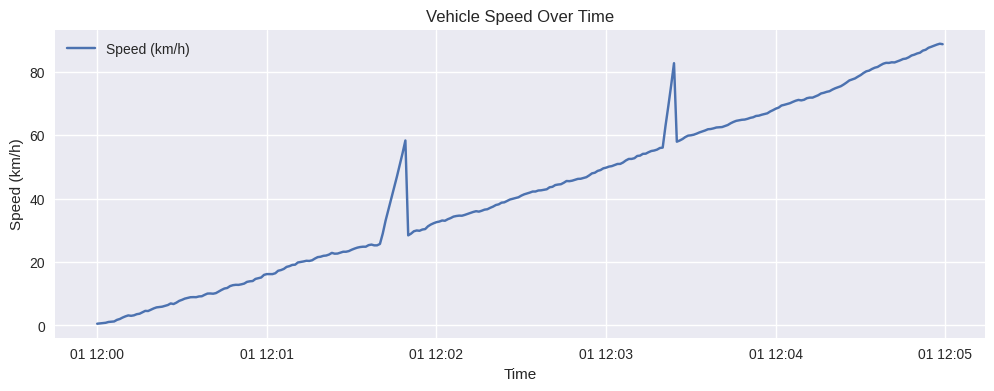

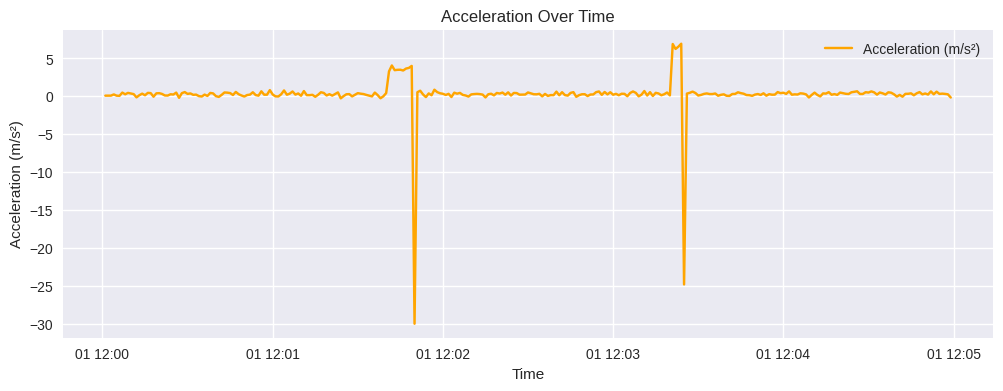

In [23]:
# 속도 시각화
plt.figure(figsize=(12, 4))
plt.plot(df['timestamp'], df['speed_kmh'], label='Speed (km/h)')
plt.title("Vehicle Speed Over Time")
plt.xlabel("Time")
plt.ylabel("Speed (km/h)")
plt.grid(True)
plt.legend()
plt.show()

# 가속도 시각화
plt.figure(figsize=(12, 4))
plt.plot(df['timestamp'], df['acceleration'], label='Acceleration (m/s²)', color='orange')
plt.title("Acceleration Over Time")
plt.xlabel("Time")
plt.ylabel("Acceleration (m/s²)")
plt.grid(True)
plt.legend()
plt.show()

🧠 Autoencoder 모델 정의 및 학습

In [24]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# 데이터 스케일링
scaler = MinMaxScaler()
X = scaler.fit_transform(df[['speed_kmh', 'acceleration']].fillna(0))

# Autoencoder 모델 정의
input_dim = X.shape[1]
inputs = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu')(inputs)
encoded = Dense(4, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(1e-3), loss='mse')
autoencoder.fit(X, X, epochs=50, batch_size=16, shuffle=True, validation_split=0.1)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.4659 - val_loss: 0.7718
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4155 - val_loss: 0.6953
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3913 - val_loss: 0.6428
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3307 - val_loss: 0.5972
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2925 - val_loss: 0.5121
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2257 - val_loss: 0.4109
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1609 - val_loss: 0.2865
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0904 - val_loss: 0.1852
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0470 - val_loss: 0.1308
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0349 - val_loss: 0.1211
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0314 - val_loss: 0.1265
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0298 - val_l

📌 이상 탐지: 재구성 오류 기반

In [25]:
# 예측 및 재구성 오차 계산
X_pred = autoencoder.predict(X)
recon_error = np.mean(np.square(X - X_pred), axis=1)
df['reconstruction_error'] = recon_error

# 임계값: 평균 + 3*표준편차
threshold = recon_error.mean() + 3 * recon_error.std()
df['anomaly'] = df['reconstruction_error'] > threshold

# 이상 탐지된 항목 확인
anomalies = df[df['anomaly'] == True]
print(f"총 {len(anomalies)}건의 이상이 탐지되었습니다.")
display(anomalies[['timestamp', 'speed_kmh', 'acceleration', 'reconstruction_error']])

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
총 2건의 이상이 탐지되었습니다.


,timestamp,speed_kmh,acceleration,reconstruction_error
110,2024-01-01 12:01:50,28.404453,-29.938576,0.160655
205,2024-01-01 12:03:25,57.956438,-24.765905,0.261155


📈 재구성 오차 및 이상치 시각화

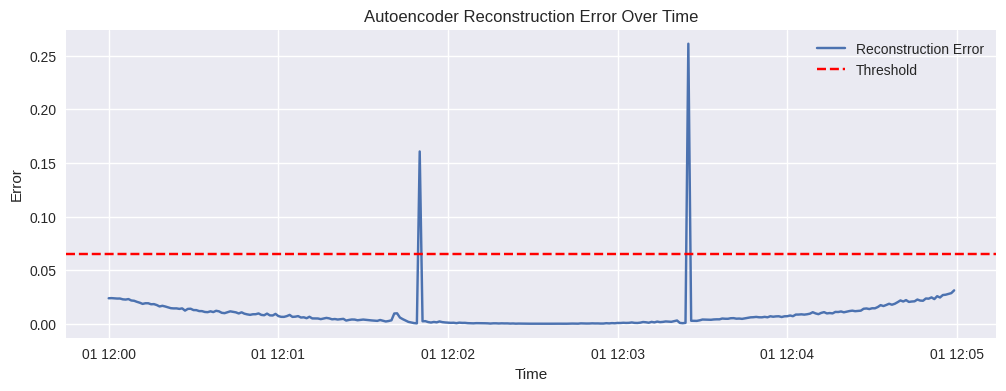

In [26]:
plt.figure(figsize=(12, 4))
plt.plot(df['timestamp'], df['reconstruction_error'], label='Reconstruction Error')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Autoencoder Reconstruction Error Over Time")
plt.xlabel("Time")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()

🚨 이상 속도 구간 시각화

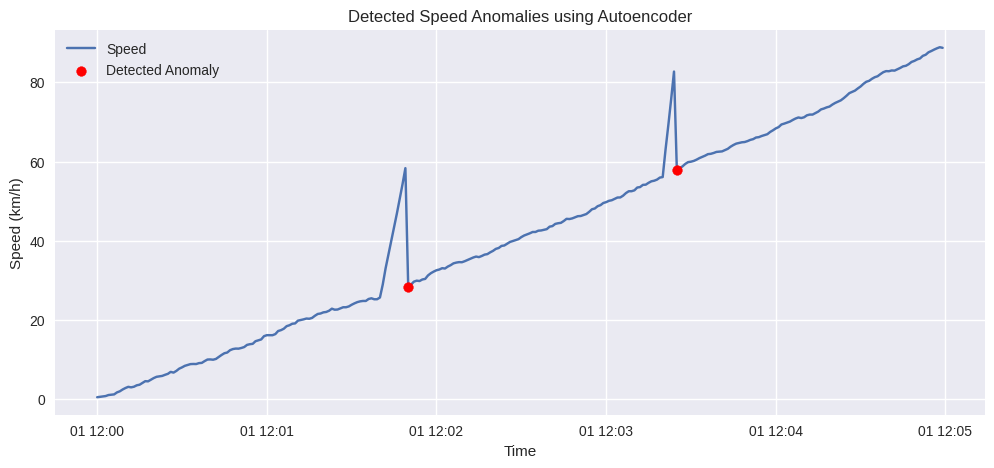

In [27]:
plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['speed_kmh'], label='Speed')
plt.scatter(anomalies['timestamp'], anomalies['speed_kmh'], color='red', label='Detected Anomaly', zorder=5)
plt.title("Detected Speed Anomalies using Autoencoder")
plt.xlabel("Time")
plt.ylabel("Speed (km/h)")
plt.legend()
plt.grid(True)
plt.show()